In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import utils as ut
import LIM_class
plt.style.use("../plotting.mplstyle")
%load_ext autoreload
%autoreload 2

In [2]:
data = xr.open_dataset("./data/ssta_1950_2021.nc")['ssta']

print("Data shape: {}".format(data.shape))
print("Data : {}".format(data))

Data shape: (864, 13, 35)
Data : <xarray.DataArray 'ssta' (time: 864, lat: 13, lon: 35)>
[393120 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2021-12-01
  * lat      (lat) float64 -30.0 -25.0 -20.0 -15.0 -10.0 ... 15.0 20.0 25.0 30.0
  * lon      (lon) float64 -60.0 -55.0 -50.0 -45.0 ... 95.0 100.0 105.0 110.0
    month    (time) int64 ...


In [3]:
# Use Principal Component Analysis to reduce the dimensionality of the data

pca_5 = ut.SpatioTemporalPCA(data, n_components=5)
pca_10 = ut.SpatioTemporalPCA(data, n_components=10)
pca_15 = ut.SpatioTemporalPCA(data, n_components=15)

print("Explained variance ratio for 5 components: {}".format(np.sum(pca_5.explained_variance())))
print("Explained variance ratio for 10 components: {}".format(np.sum(pca_10.explained_variance())))
print("Explained variance ratio for 15 components: {}".format(np.sum(pca_15.explained_variance())))

eof_5 = pca_5.eofs()
eof_10 = pca_10.eofs()
eof_15 = pca_15.eofs()

print("EOFs shape for 5 components: (eof, lat, lon) {}".format(eof_5.shape))
print("EOFs shape for 10 components: (eof, lat, lon) {}".format(eof_10.shape))
print("EOFs shape for 15 components: (eof, lat, lon) {}".format(eof_15.shape))

pc_5 = pca_5.principal_components()
pc_10 = pca_10.principal_components()
pc_15 = pca_15.principal_components()

print("PCs shape for 5 components: (eof, time) {}".format(pc_5.shape))
print("PCs data for 5 components: {}".format(pc_5))
print("PCs shape for 10 components: (eof, time) {}".format(pc_10.shape))
print("PCs shape for 15 components: (eof, time) {}".format(pc_15.shape))


Explained variance ratio for 5 components: 0.5822137849313851
Explained variance ratio for 10 components: 0.7008253293215911
Explained variance ratio for 15 components: 0.7601916491883428
EOFs shape for 5 components: (eof, lat, lon) (5, 13, 35)
EOFs shape for 10 components: (eof, lat, lon) (10, 13, 35)
EOFs shape for 15 components: (eof, lat, lon) (15, 13, 35)
PCs shape for 5 components: (eof, time) (5, 864)
PCs data for 5 components: <xarray.DataArray (eof: 5, time: 864)>
array([[ -6.29767607,  -6.92623833,  -6.06612333, ...,  -8.78229121,
        -10.73037298, -11.51841333],
       [ -1.32017408,  -0.94989198,  -0.17729696, ...,   3.58378548,
          3.30997493,   0.36169655],
       [ -2.06665431,  -2.59613487,  -2.82771506, ...,  -3.41827044,
         -4.84755592,  -4.01489776],
       [  0.20368149,   0.53551657,  -0.37872964, ...,  -1.01851237,
         -0.44631494,  -1.55271253],
       [ -0.18495496,   1.66548122,   1.91976872, ...,  -0.80688016,
          0.88244493,   1.137

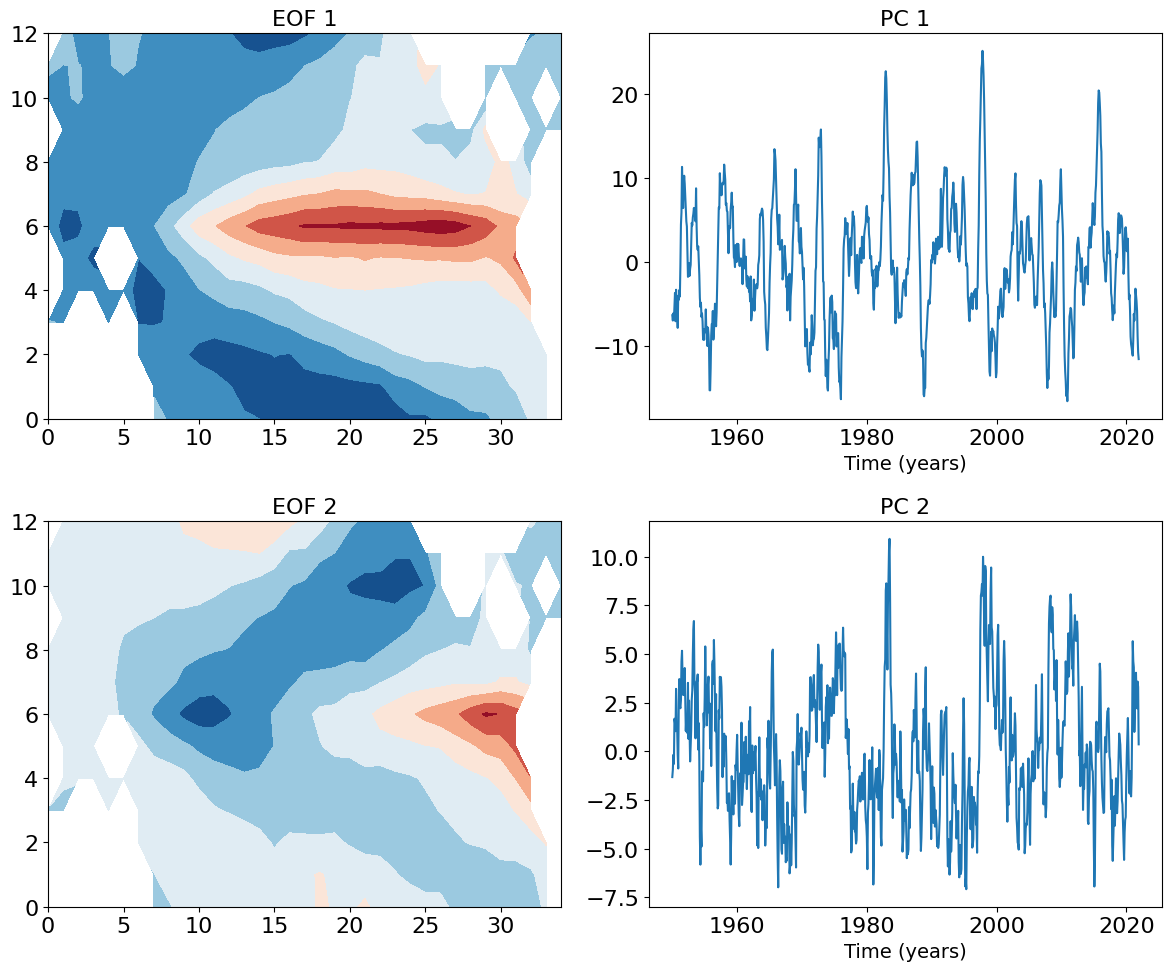

In [4]:
# Set the number of plots to 2
number_of_plots = 2

# Create the figure and axes objects
fig, axs = plt.subplots(number_of_plots, 2, figsize=(12, 10))

# Set titles and plot the contourf and plot for each EOF and PC
for i in range(number_of_plots):
    axs[i,0].set_title("EOF {}".format(i + 1), fontsize=16)
    axs[i,0].contourf(eof_10[i], cmap="RdBu_r")
    axs[i,1].set_title("PC {}".format(i + 1), fontsize=16)
    # Define time variable
    time = np.arange(len(pc_10[i]))
    # Convert time to years
    time_years = time/12 + 1950
    # Plot PC with time on x-axis in years
    axs[i,1].plot(time_years, pc_10[i])
    axs[i,1].set_xlabel("Time (years)", fontsize=14)

# Add padding between subplots and adjust layout
fig.tight_layout(pad=2)

In [5]:
# Create training and test data

data = pca_10.principal_components()
index_train = int(0.8 * len(data["time"]))
data_train = data[:, :index_train]
data_test = data[:, index_train:]

In [6]:
# Creating an example LIM object

tau = 1
model = LIM_class.LIM(tau)
model.fit(data_train.data)
print("Data train : {} + shape: {}".format(data_train.data, data_train.data.shape))

Frobenius norm: 0.7287941388248785
Data train : [[-6.29767607 -6.92623833 -6.06612333 ... -5.33055296 -4.86835222
  -6.0603949 ]
 [-1.32017404 -0.94989195 -0.17729696 ... -2.09860531 -2.16949402
  -2.62321542]
 [-2.06665346 -2.59613488 -2.82771558 ... -1.22104008 -2.50958122
  -1.09307035]
 ...
 [ 0.46676074  0.63505642  0.6357088  ... -5.22359033 -5.7977733
  -3.26081213]
 [ 1.10642357  0.45354205  0.14072    ...  1.62798121 -0.17285665
   1.00840168]
 [ 1.58742847  1.44763756  2.32771851 ... -0.99415317 -0.7870666
  -0.79283062]] + shape: (10, 691)


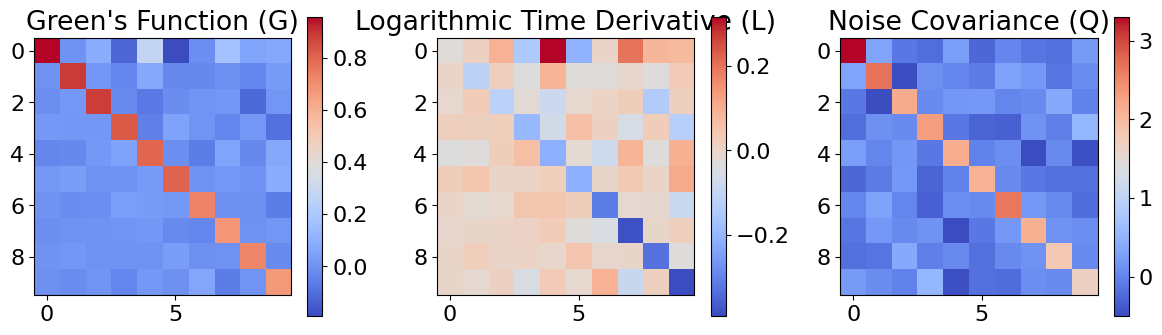

In [7]:
# Plot G, L, Q
fig, axs = plt.subplots(1, 3, figsize=(12, 3.5))

# Plot G
im1 = axs[0].imshow(model.green_function, cmap='coolwarm')
axs[0].set_title('Green\'s Function (G)')
fig.colorbar(im1, ax=axs[0])

# Plot L
im2 = axs[1].imshow(np.real(model.logarithmic_matrix), cmap='coolwarm')
axs[1].set_title('Logarithmic Time Derivative (L)')
fig.colorbar(im2, ax=axs[1])

# Plot Q
im3 = axs[2].imshow(np.real(model.noise_covariance), cmap='coolwarm')
axs[2].set_title('Noise Covariance (Q)')
fig.colorbar(im3, ax=axs[2])

plt.tight_layout()
plt.show()

In [8]:
# Model geometric brownian motion

#model.geometric_brownian_motion(mu=2)

In [9]:
# Simulate stochastic differential equation

x_input = data_test.isel(time=0)
#x_input = data_test.isel(time=np.arange(0,10))
times = x_input['time']
x = x_input.data

#forecast_output, forecast_output2 = model.forecast(x, [1,2,3])
output_array = model.noise_integration(x, timesteps=2)
print("Prediction-Array : {} + shape : {}".format(output_array, output_array.shape))

forecast_mean = 0
for ensemble in output_array[:-1]:
    forecast_mean += ensemble

forecast_mean = forecast_mean / len(output_array[:-1])
#print("Output-Array : {} + shape : {}".format(output_array, output_array.shape))
#print("Forecast mean : {}".format(forecast_mean))


State start : [-8.08248359 -3.38374856 -2.1527585  -0.78083352 -2.12457855 -0.33213785
  2.12246494 -0.99610708 -0.83563035 -1.42852564] + shape : (10,)
Deterministic part : [-0.00690705  0.00111243  0.00460216  0.00221234  0.00365966 -0.00421934
 -0.00476642  0.0024595   0.00191917  0.00739898] + shape : (10,) + type: <class 'numpy.ndarray'>
Deterministic part : [-0.01159807 -0.00467874  0.00455018  0.00428157  0.00202182 -0.00605955
 -0.01009546  0.00305564  0.00346169  0.01423832] + shape : (10,) + type: <class 'numpy.ndarray'>
Deterministic part : [-0.01665024 -0.00766899  0.00610873  0.00071511  0.0058972  -0.00451743
 -0.01338378  0.00523333  0.00273331  0.01555887] + shape : (10,) + type: <class 'numpy.ndarray'>
Deterministic part : [-0.01465178 -0.00716909  0.0035732   0.00085334  0.01143238 -0.00487684
 -0.01030112  0.00065691  0.00268894  0.01195369] + shape : (10,) + type: <class 'numpy.ndarray'>
Deterministic part : [-0.00165096 -0.00543918  0.00172602  0.00427531  0.004935

In [10]:
# Transform back to data space (denoted with y) and plot the time evolution of selected components

lag = 3

#x_input = data_test.isel(time=np.arange(0,50))
#x = x_input.data
#TODO plot hinbekommen

# Reconstruct the input and forecasted data
reconstructed_input = pca_10.reconstruction(x[:, lag:], newdim=times[lag:])
reconstructed_forecast = pca_10.reconstruction(output_array[1550, :, :-lag], newdim=times[lag:])

print(f"Reconstructed input data shape: {reconstructed_input.shape}")
print(f"Reconstructed forecast data shape: {reconstructed_forecast.shape}")

# Choose a time index to plot
time_index = 5
time_index2 = 200

# Define plot parameters
plot_params = {'tsa': dict(vmin=-2, vmax=2, eps=0.25),
               'zosa': dict(vmin=-0.1, vmax=.1, eps=0.025)}

# Plot the input and forecasted data at the chosen time index
fig, axs = plt.subplots(1,2, figsize=(10, 3))
reconstructed_input.isel(time=time_index).plot(ax=axs[0])
axs[0].set_title("Target")
reconstructed_forecast.isel(time=time_index).plot(ax=axs[1])
axs[1].set_title("Forecast")

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
#x_input = data_test.isel(time=0)
x_input = data_test.isel(time=np.arange(0,10))
times = x_input['time']
x = x_input.data

forecast_output, forecast_output2 = model.forecast(x, [1,2,3])

print("Forecast output : {} + shape: {}".format(forecast_output, forecast_output.shape))
print("Forecast2 output : {} + shape: {}".format(forecast_output2, forecast_output2.shape))


In [ ]:
#x_input = data_test.isel(time=0)
x_input = data_test.isel(time=np.arange(0,10))
times = x_input['time']
x = x_input.data

forecast_output = model.forecast_mean(x)

print("Forecast output : {} + shape: {}".format(forecast_output, forecast_output.shape))

In [ ]:
# Forecasting

# Define lag
lag = 3

# Get input data
x_input = data_test.isel(time=np.arange(0, 50))
times = x_input['time']
x = x_input.data

# Forecast mean using LIM model
x_frcst = model.forecast_mean(x, lag=lag)

# Plot time evolution of selected components
idx_components = [0, 1, 2]
fig, axs = plt.subplots(len(idx_components), figsize=(12, len(idx_components)*1.5), sharex=True)

for i, component in enumerate(idx_components):
    # Plot target data for the component
    axs[i].plot(times[lag:], x[component, lag:], label='Target')

    # Plot forecasted data using LIM model
    axs[i].plot(times[lag:], x_frcst[component, :-lag], label=f'LIM (tau={lag})')

    # Set y-axis label
    axs[i].set_ylabel(f'PC {component+1}')

# Add legend
_ = axs[0].legend(bbox_to_anchor=(1, 1), loc="upper left")

# Set x-axis label for the last subplot
axs[-1].set_xlabel('Time')

In [ ]:
# Transform back to data space (denoted with y) and plot the time evolution of selected components

# Reconstruct the input and forecasted data
reconstructed_input = pca_10.reconstruction(x[:, lag:], newdim=times[lag:])
reconstructed_forecast = pca_10.reconstruction(x_frcst[:, :-lag], newdim=times[lag:])

print(f"Reconstructed input data shape: {reconstructed_input.shape}")
print(f"Reconstructed forecast data shape: {reconstructed_forecast.shape}")

# Choose a time index to plot
time_index = 5

# Define plot parameters
plot_params = {'tsa': dict(vmin=-2, vmax=2, eps=0.25),
               'zosa': dict(vmin=-0.1, vmax=.1, eps=0.025)}

# Plot the input and forecasted data at the chosen time index
fig, axs = plt.subplots(1,2, figsize=(10, 3))
reconstructed_input.isel(time=time_index).plot(ax=axs[0])
axs[0].set_title("Target")
reconstructed_forecast.isel(time=time_index).plot(ax=axs[1])
axs[1].set_title("Forecast")